In [1]:
import numpy as np
import os
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

### 数据集读取
- Mnist数据是图像数据：(28,28,1)的灰度图

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='./dataset')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [3]:
x = mnist['data']
y = mnist['target']

In [4]:
x.shape

(70000, 784)

In [10]:
y.shape

(70000,)

In [5]:
# 划分数据集
x_train, x_test = x[:60000], x[60000:]
y_train, y_test = y[:60000], y[60000:]

In [6]:
# 洗牌操作
shuffle_index = np.random.permutation(60000)
x_train, y_train = x[shuffle_index], y[shuffle_index]

### 交叉验证
![title](./img/5.png)
![title](./img/7.png)

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [8]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=15, random_state=32)
sgd_clf.fit(x_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=15, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=32, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [9]:
sgd_clf.predict([x[35000]])

array([ True])

In [10]:
y[35000]

5.0

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, x_train, y_train_5, cv=5, scoring='accuracy')

array([0.95433714, 0.952     , 0.96716667, 0.95908333, 0.95066256])

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=5, random_state=32)
for train_index, test_index in skfolds.split(x_train, y_train_5):
    clone_clf = clone(sgd_clf)
    x_train_folds = x_train[train_index]
    y_train_folds = y_train_5[train_index]
    x_test_folds = x_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_folds)
    num_correct = sum(y_pred == y_test_folds)
    print(num_correct/len(y_pred))

0.9543371385717857
0.952
0.9671666666666666
0.9590833333333333
0.9506625552129344


### Confusion Matrix-混淆矩阵
![title](./img/8.png)

In [13]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)

In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[54125,   454],
       [ 1767,  3654]])

negative class  [[ **true negatives** , **false positives** ],
 
positive class  [ **false negatives** , **true positives** ]]

* true negatives:  54,125个数据被正确的分为非5类别
* false positives：454张被错误的分为5类别

* false negatives：1767张错误的分为非5类别
* true positives： 3654张被正确的分为5类别

一个完美的分类器应该只有**true positives** 和 **true negatives**, 即主对角线元素不为0，其余元素为0

### Precision and Recall


### **$ precision = \frac {TP} {TP + FP} $**


### **$ recall = \frac {TP} {TP + FN} $**
![title](./img/1.png)

In [15]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8894839337877313

In [16]:
recall_score(y_train_5, y_train_pred)

0.6740453790813503

将**Precision** 和 **Recall**结合到一个称为**F1 score** 的指标,调和平均值给予低值更多权重。 因此，如果召回和精确度都很高，分类器将获得高F 1分数。

### $ F_1  = $ $2\over {1\over precision}+{1\over recall} $ $=$ $2×$ $precision×recall\over precision+recall $ $=$ $TP\over {TP}+{FN + FP\over 2}$

In [17]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7669220274950151

### 阈值对结果的影响

![title](./img/2.png)

In [18]:
y_scores = sgd_clf.decision_function([x[35000]])
y_scores

array([40157.01151674])

Scikit-Learn不允许直接设置阈值，但它可以得到决策分数，调用其**decision_function（）**方法，而不是调用分类器的**predict（）**方法，该方法返回每个实例的分数，然后使用想要的**阈值**根据这些分数进行预测：

In [19]:
y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3, method='decision_function')

In [20]:
y_scores[:5]

array([-185498.38735474, -919143.86763005, -282626.1695973 ,
       -234942.6127195 , -199132.65296915])

In [21]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [24]:
precisions.shape

(59876,)

In [25]:
thresholds.shape

(59875,)

In [29]:
recalls.shape

(59876,)

In [31]:
y_train_5.shape

(60000,)

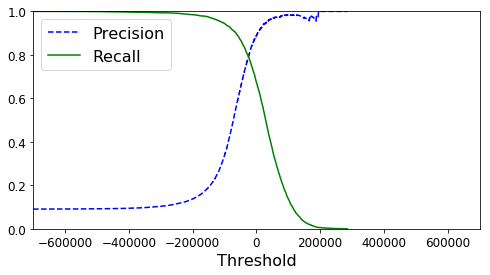

In [22]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,
             precisions[:-1],
            "b--",
            label="Precision")
    
    plt.plot(thresholds,
             recalls[:-1],
            "g-",
            label="Recall")
    plt.xlabel("Threshold",fontsize=16)
    plt.legend(loc="upper left",fontsize=16)
    plt.ylim([0,1])
    
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.xlim([-700000, 700000])
plt.show()

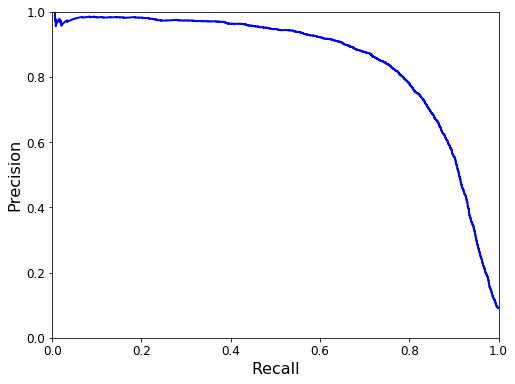

In [23]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, 
             precisions, 
             "b-", 
             linewidth=2)
    
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

### ROC curves
**receiver operating characteristic (ROC)** 曲线是二元分类中的常用评估方法
* 它与精确度/召回曲线非常相似，但ROC曲线不是绘制精确度与召回率，而是绘制**true positive rate(TPR)** 与**false positive rate(FPR)** 

* 要绘制ROC曲线，首先需要使用**roc_curve（）**函数计算各种阈值的**TPR和FPR**：

TPR = TP / (TP + FN) (Recall)

FPR = FP / (FP + TN)

In [24]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

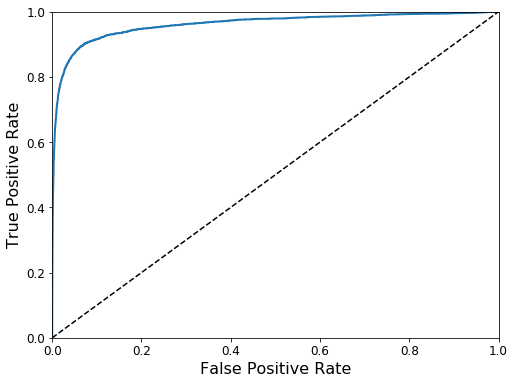

In [25]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

**虚线表示纯随机分类器的ROC曲线**; 一个好的分类器尽可能远离该线（朝左上角）。

比较分类器的一种方法是测量曲线下面积（AUC）。完美分类器的ROC AUC**等于1**，而纯随机分类器的ROC AUC**等于0.5**。 Scikit-Learn提供了计算ROC AUC的函数：

In [26]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9613122207036302